# Anamoly Detection using Variational Autoencoder (VAE)

### Project by : Deepthi D'Souza

The aim of this project is to develop and evaluate Variational Autoencoder (VAE) models for anomaly detection in machine temperature data. Anomaly detection is crucial for identifying system failures or irregularities in temperature patterns, which can help prevent malfunctions or breakdowns in industrial systems.

### Dataset information:

* The dataset contains machine temperature readings collected over time. Each row represents a timestamped observation of the machine temperature.




In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Step 1: Importing required libraries

In [6]:
# Importing necessary libraries
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Step 2: Loading datatset

In [15]:
# Read the dataset
data = pd.read_csv('machine_temperature_system_failure.csv')

# Print the main statistics about the dataset
print(data.describe())

              value
count  22695.000000
mean      85.926498
std       13.746912
min        2.084721
25%       83.080078
50%       89.408246
75%       94.016252
max      108.510543


### Step 3: Data Visualization

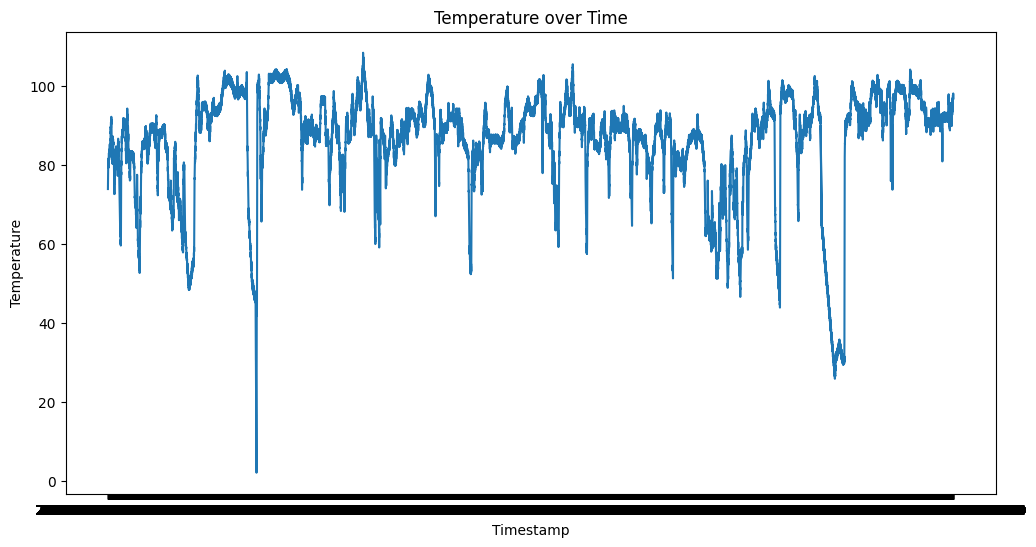

In [33]:
# Visualization 1: Line plot of temperature over time
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['value'])
plt.title('Temperature over Time')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.show()

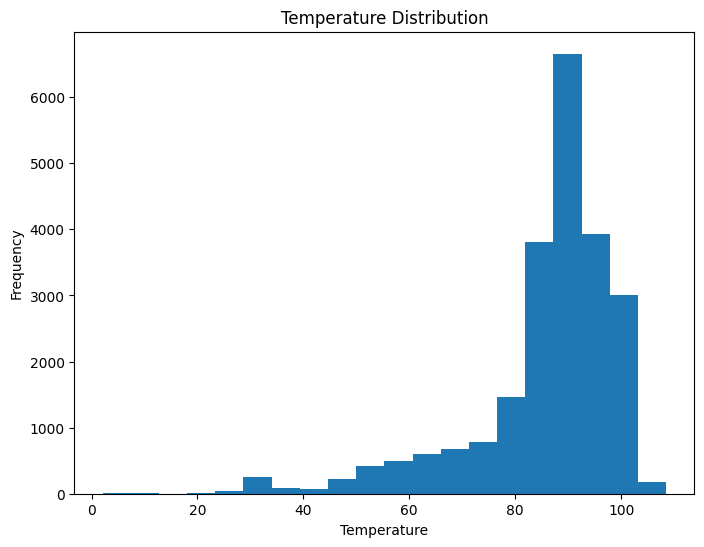

In [7]:
# Visualization 2: Histogram of temperature values
plt.figure(figsize=(8, 6))
plt.hist(data['value'], bins=20)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

<Figure size 800x600 with 0 Axes>

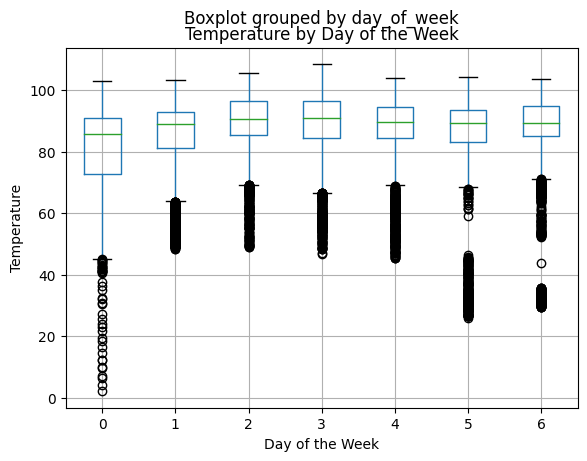

In [8]:
# Visualization 3: Box plot of temperature values by day of the week
data['day_of_week'] = pd.to_datetime(data['timestamp']).dt.dayofweek
plt.figure(figsize=(8, 6))
data.boxplot(column='value', by='day_of_week')
plt.title('Temperature by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Temperature')
plt.show()

### Step 4: Dataset split

In [22]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and testing sets
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

# Print the sizes of each set
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Testing set size:", len(test_data))


Training set size: 15886
Validation set size: 3404
Testing set size: 3405


### Step 5: Defining plot functions 

In [8]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc, test_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, 'g', label='Training accuracy')
    plt.plot(epochs, test_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss over time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Step 6: Model Building

### Setup 1: Using Dense Layers

In [23]:
import torch
import torch.nn as nn

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        # Latent layers
        self.fc_mean = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )

    def encode(self, x):
        hidden = self.encoder(x)
        mean = self.fc_mean(hidden)
        logvar = self.fc_logvar(hidden)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        reconstructed = self.decoder(z)
        return reconstructed

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar


In [24]:

# Model traning
def train_test(vae_base):

  # Set hyperparameters
  num_epochs = 100
  batch_size = 64
  learning_rate = 0.001

  # Define the loss function
  mse_loss = nn.MSELoss(reduction='mean')

  # Exclude non-numeric columns
  numeric_columns = data.select_dtypes(include=['float32', 'float64']).columns
  train_data_numeric = train_data[numeric_columns]
  val_data_numeric = val_data[numeric_columns]
  test_data_numeric = test_data[numeric_columns]

  # Define the optimizer
  optimizer = optim.Adam(vae_base.parameters(), lr=learning_rate)

  train_loss_list=[]
  train_acc_list=[]
  val_loss_list=[]
  val_acc_list=[]

  # Training loop
  for epoch in range(num_epochs):
      # Set the model in training mode
      vae_base.train()

      # Shuffle the training data
      train_data_numeric = train_data_numeric.sample(frac=1).reset_index(drop=True)

      # Initialize the loss and accuracy variables
      train_loss = 0.0
      num_correct = 0
      num_samples = 0

      # Iterate over mini-batches
      for i in range(0, len(train_data_numeric), batch_size):
          # Prepare the mini-batch
          batch = train_data_numeric[i:i+batch_size]
          inputs = torch.tensor(batch.values, dtype=torch.float32)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          reconstructed, mean, logvar = vae_base(inputs)

          # Compute the reconstruction loss
          loss = mse_loss(reconstructed, inputs)

          # Compute the KL divergence loss
          kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

          # Total loss
          total_loss = loss + kl_loss

          # Backward pass
          total_loss.backward()

          # Update the weights
          optimizer.step()

          # Update the training loss
          train_loss += total_loss.item() * inputs.size(0)

          # Calculate the number of correct predictions
          num_samples += inputs.size(0)

      # Calculate the average training loss and accuracy
      train_loss /= num_samples
      train_accuracy = 1.0 - train_loss / torch.mean(inputs**2)

      # Set the model in evaluation mode
      vae_base.eval()

      # Calculate the validation loss
      with torch.no_grad():
          val_inputs = torch.tensor(val_data_numeric.values, dtype=torch.float32)
          val_reconstructed, val_mean, val_logvar = vae_base(val_inputs)
          val_loss = mse_loss(val_reconstructed, val_inputs)
          val_accuracy = 1.0 - train_loss / torch.mean(val_inputs**2)


      val_loss_list.append(val_loss)
      val_acc_list.append(val_accuracy)
      train_loss_list.append(train_loss)
      train_acc_list.append(train_accuracy)

      # Validation
      if (epoch+1) % 10 == 0:

        # Print the epoch, training loss, training accuracy, and validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}")


  # Testing
  vae_base.eval()
  test_inputs = torch.tensor(test_data_numeric.values, dtype=torch.float32)
  test_reconstructed, test_mean, test_logvar = vae_base(test_inputs)
  test_loss = mse_loss(test_reconstructed, test_inputs)
  test_accuracy = (1.0 - (test_loss / torch.mean(test_inputs**2)))*100
  print(f"Testing Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy.item():.4f}")

  plot_accuracy(train_acc_list,val_acc_list)
  plot_loss(train_loss_list,val_loss_list)

  return vae_base.state_dict()



Epoch [10/100], Train Loss: 115.7368, Train Accuracy: 0.9849, Validation Loss: 39.0016, Validation Accuracy: 0.9848
Epoch [20/100], Train Loss: 84.3394, Train Accuracy: 0.9883, Validation Loss: 28.8449, Validation Accuracy: 0.9889
Epoch [30/100], Train Loss: 82.3321, Train Accuracy: 0.9901, Validation Loss: 32.7604, Validation Accuracy: 0.9892
Epoch [40/100], Train Loss: 82.9793, Train Accuracy: 0.9897, Validation Loss: 29.5372, Validation Accuracy: 0.9891
Epoch [50/100], Train Loss: 78.5001, Train Accuracy: 0.9900, Validation Loss: 34.0961, Validation Accuracy: 0.9897
Epoch [60/100], Train Loss: 77.4649, Train Accuracy: 0.9886, Validation Loss: 28.5301, Validation Accuracy: 0.9898
Epoch [70/100], Train Loss: 77.5366, Train Accuracy: 0.9900, Validation Loss: 36.3855, Validation Accuracy: 0.9898
Epoch [80/100], Train Loss: 77.4063, Train Accuracy: 0.9904, Validation Loss: 31.8206, Validation Accuracy: 0.9898
Epoch [90/100], Train Loss: 78.0627, Train Accuracy: 0.9909, Validation Loss: 3

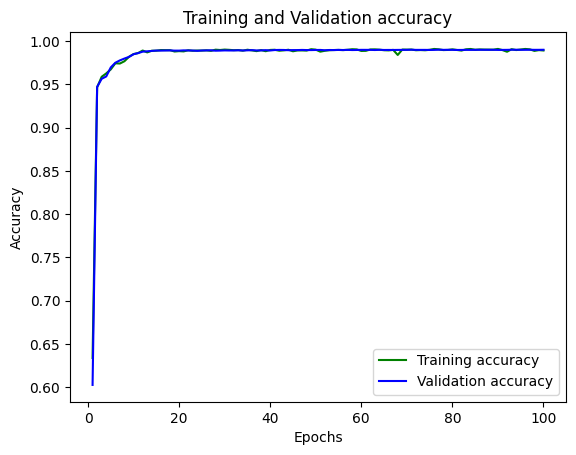

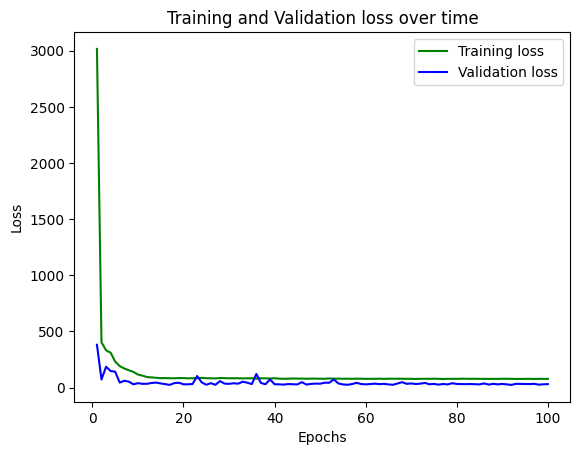

In [25]:
# initializing hyperparameters
input_size = len(data.columns)  # Number of input features
hidden_size = 64  # Size of hidden layers
latent_size = 2  # Size of the latent space

# Exclude non-numeric columns
numeric_columns = data.select_dtypes(include=['float32', 'float64']).columns

# Create the VAE model (base setup)
vae_base = VAE(len(numeric_columns), hidden_size, latent_size)

# model training function call
vae_dense_weights = train_test(vae_base)

# Save weights to a pickle file
import pickle

pickle_out = open("vae_dense.pickle", "wb")
pickle.dump(vae_dense_weights, pickle_out)
pickle_out.close()

### Setup 2: using LSTM

In [31]:
import torch
import torch.nn as nn

class VAE_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE_LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.latent_size = latent_size

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.encoder = nn.Linear(hidden_size, latent_size * 2)
        self.decoder = nn.Linear(latent_size, hidden_size)
        self.output = nn.Linear(hidden_size, input_size)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean

    def forward(self, x):
        _, (h, _) = self.lstm(x)  # Use only the last hidden state
        h = h.squeeze(0)  # Remove the sequence length dimension
        output = self.encoder(h)
        mean, logvar = torch.chunk(output, 2, dim=-1)  # Split into mean and logvar
        z = self.reparameterize(mean, logvar)
        output = self.decoder(z)
        reconstructed = self.output(output)
        return reconstructed, mean, logvar


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3404, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Epoch [10/100], Train Loss: 214.4946, Train Accuracy: 0.9696, Validation Loss: 193.1126, Validation Accuracy: 0.9718
Epoch [20/100], Train Loss: 201.3848, Train Accuracy: 0.9742, Validation Loss: 195.7178, Validation Accuracy: 0.9735
Epoch [30/100], Train Loss: 197.9511, Train Accuracy: 0.9732, Validation Loss: 195.0515, Validation Accuracy: 0.9739
Epoch [40/100], Train Loss: 197.1783, Train Accuracy: 0.9729, Validation Loss: 205.8256, Validation Accuracy: 0.9740
Epoch [50/100], Train Loss: 196.0916, Train Accuracy: 0.9759, Validation Loss: 205.7821, Validation Accuracy: 0.9742
Epoch [60/100], Train Loss: 196.3798, Train Accuracy: 0.9725, Validation Loss: 215.3203, Validation Accuracy: 0.9741
Epoch [70/100], Train Loss: 195.7324, Train Accuracy: 0.9767, Validation Loss: 213.7819, Validation Accuracy: 0.9742
Epoch [80/100], Train Loss: 195.8913, Train Accuracy: 0.9758, Validation Loss: 203.4588, Validation Accuracy: 0.9742
Epoch [90/100], Train Loss: 195.7973, Train Accuracy: 0.9756, Va

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3405, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


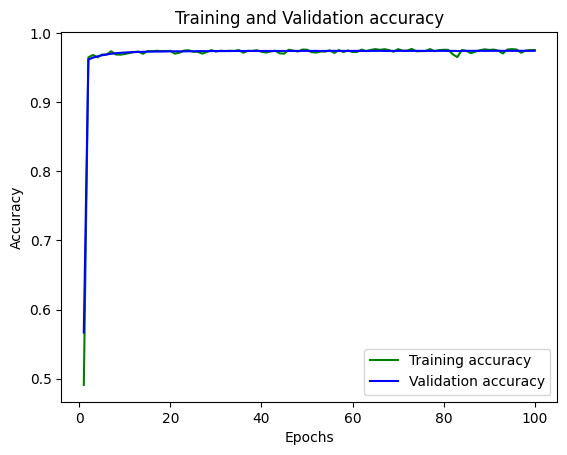

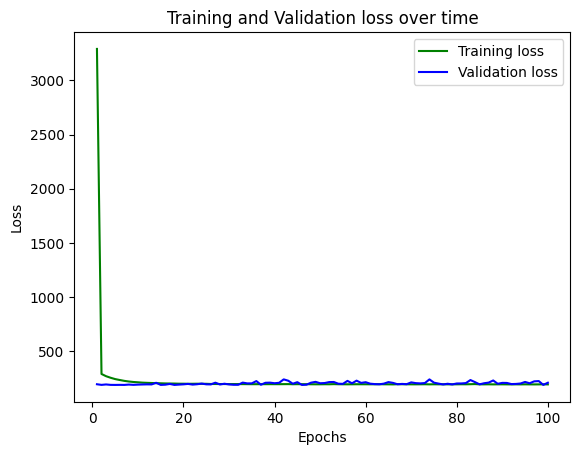

In [32]:

input_size = len(data.columns)  # Number of input features
hidden_size = 64  # Size of hidden layers
latent_size = 2  # Size of the latent space

# Exclude non-numeric columns
numeric_columns = data.select_dtypes(include=['float32', 'float64']).columns

# Create the VAE model (base setup)
vae_lstm = VAE_LSTM(len(numeric_columns), hidden_size, latent_size)

vae_lstm_weights = train_test(vae_lstm)

# Save weights to a pickle file
import pickle

pickle_out = open("vae_lstm.pickle", "wb")
pickle.dump(vae_lstm_weights, pickle_out)
pickle_out.close()

### Setup 3 : using Conv1D

In [28]:
import torch
import torch.nn as nn

class VAE_CONV(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE_CONV, self).__init__()

        self.hidden_size = hidden_size
        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            nn.Conv1d(input_size, hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.fc_mean = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(latent_size, hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, input_size, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        hidden = self.encoder(x)
        hidden = hidden.view(hidden.size(0), -1)  # Flatten the tensor
        mean = self.fc_mean(hidden)
        logvar = self.fc_logvar(hidden)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        z = z.unsqueeze(2)  # Add the temporal dimension back
        reconstructed = self.decoder(z)
        return reconstructed

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar


Epoch [10/100], Train Loss: 133.9653, Train Accuracy: 0.9802, Validation Loss: 34.9733, Validation Accuracy: 0.9824
Epoch [20/100], Train Loss: 81.5284, Train Accuracy: 0.9896, Validation Loss: 48.1181, Validation Accuracy: 0.9893
Epoch [30/100], Train Loss: 81.7585, Train Accuracy: 0.9884, Validation Loss: 36.1725, Validation Accuracy: 0.9892
Epoch [40/100], Train Loss: 80.3076, Train Accuracy: 0.9888, Validation Loss: 30.4603, Validation Accuracy: 0.9894
Epoch [50/100], Train Loss: 79.7759, Train Accuracy: 0.9896, Validation Loss: 26.8358, Validation Accuracy: 0.9895
Epoch [60/100], Train Loss: 77.7824, Train Accuracy: 0.9895, Validation Loss: 32.7853, Validation Accuracy: 0.9898
Epoch [70/100], Train Loss: 77.4325, Train Accuracy: 0.9906, Validation Loss: 30.0557, Validation Accuracy: 0.9898
Epoch [80/100], Train Loss: 79.3318, Train Accuracy: 0.9893, Validation Loss: 31.7431, Validation Accuracy: 0.9896
Epoch [90/100], Train Loss: 78.5140, Train Accuracy: 0.9909, Validation Loss: 2

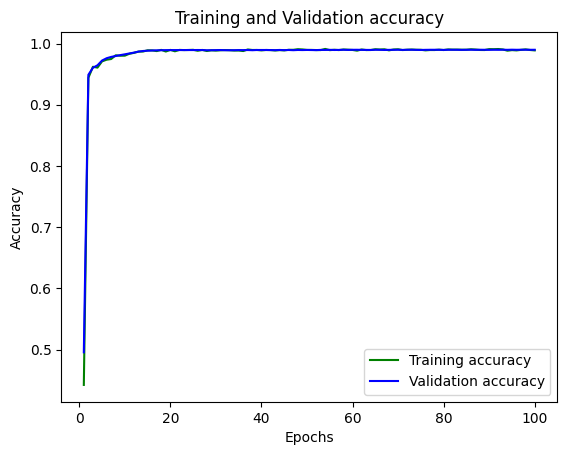

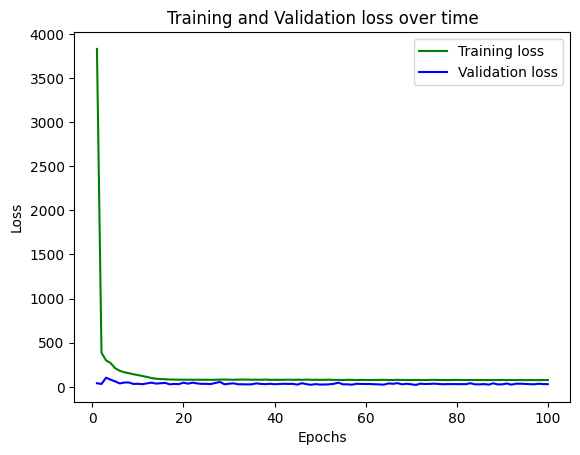

In [30]:
# Create the VAE_CONV model
vae_conv = VAE_CONV(len(numeric_columns), hidden_size, latent_size)

# Train and test the VAE_CONV model
vae_conv_weights = train_test(vae_conv)

# Save weights to a pickle file
pickle_out = open("vae_conv.pickle", "wb")
pickle.dump(vae_conv_weights, pickle_out)
pickle_out.close()